In [1]:
import sys
sys.path.append('../drake')

import numpy as np
import pandas as pd
import seaborn as sns

from static import countries, indices
from utils import Entity
from cluster import ConsensusClustering

In [2]:
cols = [str(i) for i in range(1991, 2019)]
cols = ["Country Name", "Indicator Name"] + cols

data = pd.read_csv(
    "../data/WDI_csv/WDIData.csv",
    usecols=cols
)

In [3]:
data = data[data["Country Name"].isin(countries)].reset_index(drop=True)
data = data[data["Indicator Name"].isin(indices)].reset_index(drop=True)
data

,Country Name,Indicator Name,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Albania,"Foreign direct investment, net (BoP, current US$)",NaN,-2.000000e+07,-5.800000e+07,-5.300000e+07,-7.000000e+07,-9.010000e+07,-4.750000e+07,-4.501000e+07,...,-9.507614e+08,-1.043512e+09,-8.466167e+08,-8.348030e+08,-1.225674e+09,-1.074294e+09,-9.102567e+08,-1.037329e+09,-1.128922e+09,-1.208920e+09
1,Albania,GDP (current US$),1.099559e+09,6.521750e+08,1.185315e+09,1.880952e+09,2.392765e+09,3.199643e+09,2.258516e+09,2.545967e+09,...,1.204422e+10,1.192696e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.186135e+10,1.302506e+10,1.510250e+10
2,Albania,Gross domestic savings (current US$),-1.880236e+08,-5.668191e+08,-4.562474e+08,-2.973055e+08,-1.296032e+08,-1.148987e+08,-1.890782e+08,-1.390249e+08,...,9.669072e+08,1.280162e+09,1.382727e+09,1.378375e+09,1.142852e+09,1.026611e+09,9.331103e+08,9.215835e+08,1.145142e+09,1.391769e+09
3,Albania,"Inflation, consumer prices (annual %)",NaN,2.260054e+02,8.500475e+01,2.256505e+01,7.793219e+00,1.272548e+01,3.318027e+01,2.064286e+01,...,2.231397e+00,3.622335e+00,3.429123e+00,2.031596e+00,1.937618e+00,1.625865e+00,1.896174e+00,1.275432e+00,1.986661e+00,2.028060e+00
4,Albania,"Labor force participation rate, total (% of to...",6.483500e+01,6.487100e+01,6.409800e+01,6.332700e+01,6.232000e+01,6.198900e+01,6.264100e+01,6.237200e+01,...,5.452100e+01,5.427000e+01,5.501800e+01,5.586100e+01,5.230900e+01,5.295200e+01,5.504100e+01,5.550200e+01,5.590800e+01,5.585300e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,United States,Gross domestic savings (current US$),1.209823e+12,1.274385e+12,1.333535e+12,1.458170e+12,1.535416e+12,1.655638e+12,1.820236e+12,1.917962e+12,...,2.176122e+12,2.296074e+12,2.389718e+12,2.674213e+12,2.935633e+12,3.133576e+12,3.318772e+12,3.287282e+12,3.416120e+12,3.641363e+12
514,United States,"Inflation, consumer prices (annual %)",4.234964e+00,3.028820e+00,2.951657e+00,2.607442e+00,2.805420e+00,2.931204e+00,2.337690e+00,1.552279e+00,...,-3.555463e-01,1.640043e+00,3.156842e+00,2.069337e+00,1.464833e+00,1.622223e+00,1.186271e-01,1.261583e+00,2.130110e+00,2.442583e+00
515,United States,"Labor force participation rate, total (% of to...",6.506400e+01,6.533300e+01,6.523100e+01,6.568200e+01,6.582700e+01,6.600100e+01,6.632700e+01,6.629700e+01,...,6.430600e+01,6.356900e+01,6.300000e+01,6.304600e+01,6.250100e+01,6.219600e+01,6.200700e+01,6.215800e+01,6.229400e+01,6.231300e+01
516,United States,"Net trade in goods (BoP, current US$)",-7.694000e+10,-9.689700e+10,-1.324510e+11,-1.658310e+11,-1.741700e+11,-1.910000e+11,-1.984280e+11,-2.482210e+11,...,-5.096960e+11,-6.486730e+11,-7.409970e+11,-7.411180e+11,-7.005380e+11,-7.499170e+11,-7.618660e+11,-7.498010e+11,-8.051970e+11,-8.873360e+11


In [4]:
grouped = data.groupby("Country Name")
entity_set = {}

for (name, group) in grouped:
    entity = group.drop("Country Name", axis=1).set_index("Indicator Name").T
    entity = entity[indices]
    raw_mean = entity.mean().to_numpy()
    raw_variance = entity.var().to_numpy()
    scaled_mean = (raw_mean - np.mean(raw_mean)) / np.std(raw_mean)
    scaled_variance = (raw_variance - np.mean(raw_variance)) / np.std(raw_variance)
    corr = entity.corr().to_numpy()
    entity_set[name] = Entity(name, corr, scaled_mean, scaled_variance)

In [5]:
entity_set["India"].dragon[:]

array([ 2.32406163, -0.4971928 , -0.4971928 , -0.66829923, -0.4971928 ,
       -0.52764417,  0.36346017,  2.43650653, -0.46024105, -0.46024105,
       -0.43783967, -0.46024105, -0.45953691, -0.15840681, -0.38243705,
       -0.01556378, -0.02810203,  0.91700924,  0.93805504, -0.91100531,
       -0.96404013,  0.85414554,  0.13880067,  0.31642895, -0.19432496,
       -0.92446902,  0.30785458,  0.15476263, -0.93977997, -0.15924733,
        0.38544683, -0.97889515, -0.92314544, -0.3832459 ,  0.99496742])

In [6]:
# groups = data.groupby("Indicator Name")
# 
# cols = [str(i) for i in range(1991, 2019)]
# cols = ["Country Name"] + cols
# 
# valid_countries = set(countries)
# for i in indices:
#     temp = groups.get_group(i).loc[:, cols]
#     temp_countries = temp[(temp.isnull().sum(axis=1) < 2)]["Country Name"].tolist()
#     valid_countries = valid_countries.intersection(temp_countries)
#     
# len(valid_countries)

In [7]:
mat = []

for k, v in entity_set.items():
    mat.append(v.dragon)
    
mat = np.array(mat)
mat

array([[ 2.37178915, -0.2884212 , -0.2884212 , ..., -0.95493054,
        -0.58957934,  0.94375082],
       [ 2.36643715, -0.50250541, -0.50250541, ..., -0.89863518,
        -0.65223955,  0.99582986],
       [ 2.23879155, -0.59836727, -0.59836727, ..., -0.02126187,
        -0.60515982,  0.97592264],
       ...,
       [ 2.36852209, -0.47034789, -0.47034789, ..., -0.7600081 ,
         0.51776727,  0.99293202],
       [ 2.41378178, -0.45325527, -0.45325527, ..., -0.29979536,
        -0.6731451 ,  0.96582503],
       [ 2.40491878, -0.46703006, -0.46703006, ..., -0.15744703,
        -0.19734853,  0.97190282]])

In [8]:
cluster = ConsensusClustering(n_clusters=list(range(2, 9)), iterations=1000, random_state=42)
cluster = cluster.fit(mat)

Clustering using k=2



Clustering using k=3



Clustering using k=4



Clustering using k=5



Clustering using k=6



Clustering using k=7



Clustering using k=8


In [9]:
cluster.scores

{2: 315.67008345444015,
 3: 395.1868525784372,
 4: 189.3008530582212,
 5: 86.52989755357355,
 6: 78.25465246381113,
 7: 62.69245902134248,
 8: 66.44614512200863}

In [10]:
cluster.hierarchical_clusters

array([[0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 2., 0., 2., 0., 2., 1., 2., 0., 0., 2., 2., 2., 0.,
        2., 2., 2., 1., 0., 0., 2., 0., 1., 2., 2., 2., 2., 0., 2., 1.,
        2., 2., 0., 1., 1., 2., 0., 0., 2., 0., 2., 2., 1., 2., 1., 0.,
        1., 0., 0., 2., 2., 0., 0., 1., 2., 1., 0., 1., 0., 0., 1., 2.,
        1., 0., 0., 1., 0., 1., 1., 2., 2., 1.],
       [3., 1., 0., 2., 0., 1., 1., 1., 3., 1., 1., 0., 1., 2., 2., 0.,
        2., 1., 2., 3., 0., 0., 2., 0., 3., 2., 2., 2., 2., 0., 2., 3.,
        1., 2., 0., 3., 3., 2., 0., 0., 2., 0., 2., 2., 3., 1., 3., 0.,
        3., 0., 0., 2., 2., 1., 1., 3., 2., 3., 0., 3., 0., 0., 3., 2.,
        3., 0., 0., 3., 0., 3., 3., 2.

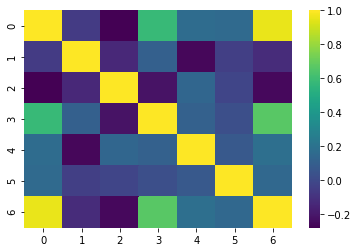

In [11]:
clus = np.arange(74)[cluster.hierarchical_clusters[2] == 0]

t = dict(zip(np.arange(74), entity_set.keys()))
r = {k: v for k, v in t.items() if k in clus}

temp = []

for coun in r.values():
    temp.append(entity_set[coun]._correlation)
    
sns.heatmap(np.array(temp).mean(axis=0), cmap="viridis")

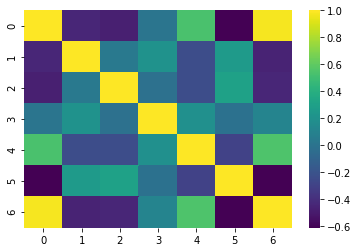

In [12]:
clus = np.arange(74)[cluster.hierarchical_clusters[2] == 1]

t = dict(zip(np.arange(74), entity_set.keys()))
r = {k: v for k, v in t.items() if k in clus}

temp = []

for coun in r.values():
    temp.append(entity_set[coun]._correlation)
    
sns.heatmap(np.array(temp).mean(axis=0), cmap="viridis")

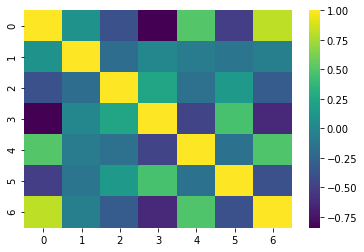

In [13]:
clus = np.arange(74)[cluster.hierarchical_clusters[2] == 2]

t = dict(zip(np.arange(74), entity_set.keys()))
r = {k: v for k, v in t.items() if k in clus}

temp = []

for coun in r.values():
    temp.append(entity_set[coun]._correlation)
    
sns.heatmap(np.array(temp).mean(axis=0), cmap="viridis")

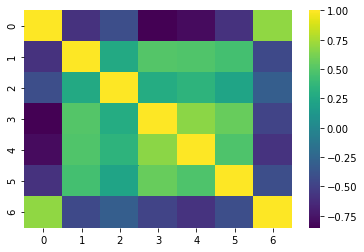

In [14]:
clus = np.arange(74)[cluster.hierarchical_clusters[2] == 3]

t = dict(zip(np.arange(74), entity_set.keys()))
r = {k: v for k, v in t.items() if k in clus}

temp = []

for coun in r.values():
    temp.append(entity_set[coun]._correlation)
    
sns.heatmap(np.array(temp).mean(axis=0), cmap="viridis")